### 1.按公司文件分开训练模型

GPU 可用，使用 GPU 加速
Epoch 1/100, Validation Loss: 0.2729862779378891
Epoch 2/100, Validation Loss: 0.14746040850877762
Epoch 3/100, Validation Loss: 0.03747096750885248
Epoch 4/100, Validation Loss: 0.05511445179581642
Epoch 5/100, Validation Loss: 0.12393910810351372
Epoch 6/100, Validation Loss: 0.009830016177147627
Epoch 7/100, Validation Loss: 0.03746276907622814
Epoch 8/100, Validation Loss: 0.112571582198143
Epoch 9/100, Validation Loss: 0.16601963341236115
Epoch 10/100, Validation Loss: 0.17498517036437988
Epoch 11/100, Validation Loss: 0.18427255749702454
Epoch 12/100, Validation Loss: 0.17303694039583206
Epoch 13/100, Validation Loss: 0.1653900220990181
Epoch 14/100, Validation Loss: 0.1467335820198059
Epoch 15/100, Validation Loss: 0.1282694935798645
Epoch 16/100, Validation Loss: 0.10738322138786316
Epoch 17/100, Validation Loss: 0.07668203115463257
Epoch 18/100, Validation Loss: 0.04952884651720524
Epoch 19/100, Validation Loss: 0.025735758244991302
Epoch 20/100, Validation Lo

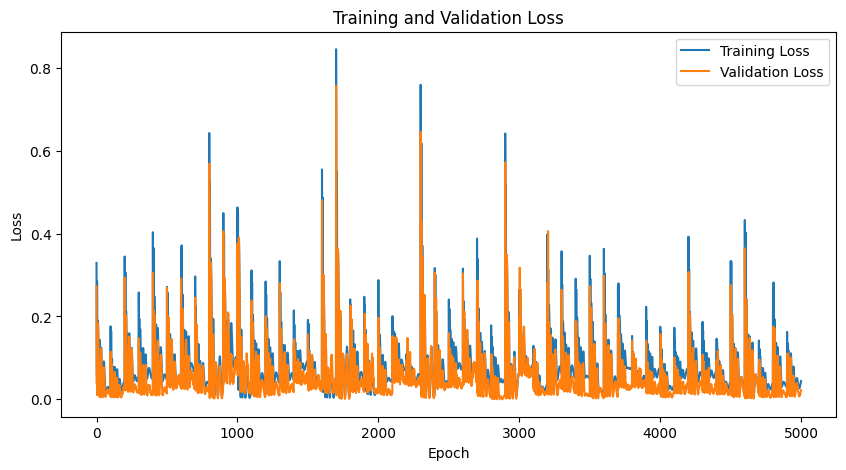

000001.SZ_平安银行_all2.xlsx: MAE=0.06927561014890671, MSE=0.00849993247538805, R2=-0.71139762274509
000002.SZ_万科A_all2.xlsx: MAE=0.19699232280254364, MSE=0.05052972957491875, R2=0.026737815628644745
000063.SZ_中兴通讯_all2.xlsx: MAE=0.0884273424744606, MSE=0.012594765983521938, R2=-0.4183894313297625
000100.SZ_TCL科技_all2.xlsx: MAE=0.11033469438552856, MSE=0.020820600911974907, R2=-0.14877647700169683
000157.SZ_中联重科_all2.xlsx: MAE=0.10024575144052505, MSE=0.02207355387508869, R2=-0.28555794940944357
000166.SZ_申万宏源_all2.xlsx: MAE=0.10428905487060547, MSE=0.019806742668151855, R2=-0.1824346942783741
000301.SZ_东方盛虹_all2.xlsx: MAE=0.10242080688476562, MSE=0.017091181129217148, R2=-0.064040094837293
000333.SZ_美的集团_all2.xlsx: MAE=0.12871362268924713, MSE=0.028633080422878265, R2=-0.49400452577030096
000338.SZ_潍柴动力_all2.xlsx: MAE=0.1780034303665161, MSE=0.03272784501314163, R2=-30.174520770451664
000408.SZ_藏格矿业_all2.xlsx: MAE=0.14589759707450867, MSE=0.026434464380145073, R2=-0.6525906206159211
00042

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt


def create_sequences(input_data, target_data, seq_length):
    """
    创建时间序列数据窗口
    :param input_data: 输入数据
    :param target_data: 目标数据
    :param seq_length: 时间序列长度
    :return: 序列输入和序列目标
    """
    sequences_x = []
    sequences_y = []
    for i in range(len(input_data) - seq_length):
        sequences_x.append(input_data[i:i + seq_length])
        sequences_y.append(target_data[i + seq_length])
    return np.array(sequences_x), np.array(sequences_y)


def load_and_preprocess_data(file_path):
    """
    加载并预处理数据
    :param file_path: 文件路径
    :return: 预处理后的序列数据
    """
    # 假设我们想要跳过名为'所属申万行业名称(2014)_[行业级别]一级行业'和'股票收益率1'的列
    skip_column_names = ['所属申万行业名称(2014)_[行业级别]一级行业', '股票收益率1']
    all_columns = pd.read_excel(file_path, nrows=0).columns
    columns_to_use = [col for col in all_columns if col not in skip_column_names]
    data = pd.read_excel(file_path, usecols=columns_to_use)
    data = data.iloc[7:, 1:]
    x = data.iloc[:, 3:11].values
    y = data.iloc[:, -5].values
    # 数据标准化
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    x_scaled = scaler_x.fit_transform(x)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))
    return x_scaled, y_scaled


def train_and_evaluate_model(model, train_loader, val_loader, test_loader, num_epochs, learning_rate, device):
    """
    训练和评估模型
    :param model: 模型
    :param train_loader: 训练数据加载器
    :param val_loader: 验证数据加载器
    :param test_loader: 测试数据加载器
    :param num_epochs: 训练轮数
    :param learning_rate: 学习率
    :param device: 运行设备
    :return: 训练损失列表，验证损失列表，测试集上的 MAE, MSE, R2 指标
    """
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            # optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        train_losses.append(epoch_train_loss / len(train_loader))
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, targets).item()
        val_losses.append(val_loss / len(val_loader))
        print(f'Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_loss / len(val_loader)}')

    # 验证模型，求mse,mae,r^2
    model.eval()
    test_loss = 0
    test_predictions = []
    test_targets = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            test_loss += criterion(outputs, targets).item()
            test_predictions.extend(outputs.cpu().numpy().flatten())
            test_targets.extend(targets.cpu().numpy().flatten())
    test_loss /= len(test_loader)
    mae = mean_absolute_error(test_targets, test_predictions)
    mse = mean_squared_error(test_targets, test_predictions)
    # 修正此处的变量名错误
    r2 = r2_score(test_targets, test_predictions)
    return train_losses, val_losses, mae, mse, r2


def main():
    folder_path = 'E:/2412毕业论文/0104数据特征/wind250109/0109沪深300股票1/处理2/处理'
    time_windows = 10
    num_epochs = 100
    learning_rate = 0.001
    input_size = 8  # 因为 x 是 data.iloc[:, 3:11].values
    hidden_size = 50
    num_layers = 2
    output_size = 1


    # 检查设备
    if torch.cuda.is_available():
        device = torch.device("cuda:0")  # 使用第一个 GPU
        print("GPU 可用，使用 GPU 加速")
    else:
        device = torch.device("cpu")
        print("GPU 不可用，使用 CPU")


    all_train_losses = []
    all_val_losses = []
    all_mae = []
    all_mse = []
    all_r2 = []


    for file in os.listdir(folder_path):
        if file.endswith('.xlsx'):
            file_path = os.path.join(folder_path, file)
            x_scaled, y_scaled = load_and_preprocess_data(file_path)
            sequences_x, sequences_y = create_sequences(x_scaled, y_scaled, time_windows) #滑动窗口
            sequences_x = torch.FloatTensor(sequences_x).to(device)
            sequences_y = torch.FloatTensor(sequences_y).to(device)
            train_size = int(0.7 * len(sequences_x))
            val_size = int(0.2 * len(sequences_x))
            test_size = len(sequences_x) - train_size - val_size
            train_x = sequences_x[:train_size]
            train_y = sequences_y[:train_size]
            val_x = sequences_x[train_size:train_size + val_size]
            val_y = sequences_y[train_size:train_size + val_size]
            test_x = sequences_x[train_size + val_size:]
            test_y = sequences_y[train_size + val_size:]
            train_dataset = TensorDataset(train_x, train_y)
            val_dataset = TensorDataset(val_x, val_y)
            test_dataset = TensorDataset(test_x, test_y)
            # 添加 shuffle=True 以打乱数据
            train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
            test_loader = DataLoader(test_dataset, batch_size=32)
            model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
            train_losses, val_losses, mae, mse, r2 = train_and_evaluate_model(model, train_loader, val_loader, test_loader, num_epochs, learning_rate, device)
            all_train_losses.extend(train_losses)
            all_val_losses.extend(val_losses)
            all_mae.append(mae)
            all_mse.append(mse)
            all_r2.append(r2)


    # 绘制损失曲线
    plt.figure(figsize=(10, 5))
    plt.plot(all_train_losses, label='Training Loss')
    plt.plot(all_val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()


    # 输出每个公司的指标结果
    for i, file in enumerate(os.listdir(folder_path)):
        if file.endswith('.xlsx'):
            print(f'{file}: MAE={all_mae[i]}, MSE={all_mse[i]}, R2={all_r2[i]}')

    # 存储模型
    model_save_path = 'best_lstm_model.pth'
    torch.save(model.state_dict(), model_save_path)
    print(f"模型已存储在 {model_save_path}")
    
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)


    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out


if __name__ == "__main__":
    main()

### 2.把所有公司文件放一块训练模型

GPU 可用，使用 GPU 加速
Epoch 1/600, Validation Loss: 0.02992140348266128
Epoch 2/600, Validation Loss: 0.02642432080817894
Epoch 3/600, Validation Loss: 0.023734232646898484
Epoch 4/600, Validation Loss: 0.025382557241114934
Epoch 5/600, Validation Loss: 0.02381092853660525
Epoch 6/600, Validation Loss: 0.03009496519053486
Epoch 7/600, Validation Loss: 0.022914097670623114
Epoch 8/600, Validation Loss: 0.022741652775923132
Epoch 9/600, Validation Loss: 0.02242776929912433
Epoch 10/600, Validation Loss: 0.02179594379915318
Epoch 11/600, Validation Loss: 0.021852785236084124
Epoch 12/600, Validation Loss: 0.02327103598017088
Epoch 13/600, Validation Loss: 0.022012039953449244
Epoch 14/600, Validation Loss: 0.021744018538632025
Epoch 15/600, Validation Loss: 0.023692472955920328
Epoch 16/600, Validation Loss: 0.02044255725882003
Epoch 17/600, Validation Loss: 0.02064827656452085
Epoch 18/600, Validation Loss: 0.02068505394862781
Epoch 19/600, Validation Loss: 0.020948852858388087
Epoch 20/600, 

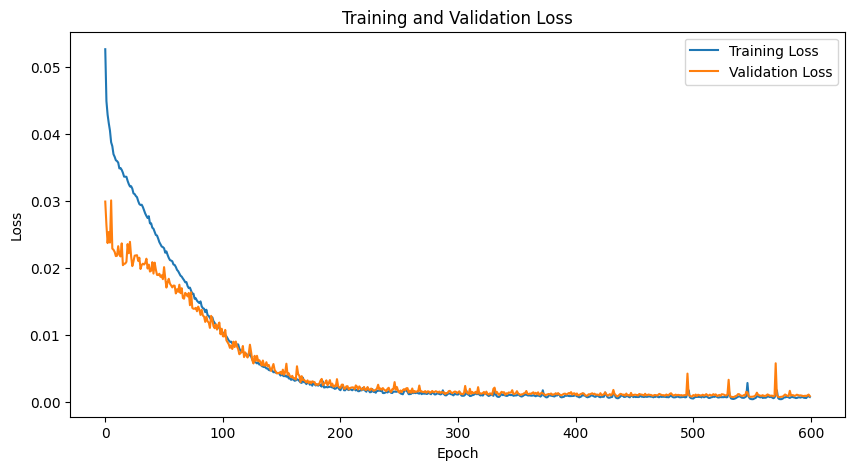

000001.SZ_平安银行_all2.xlsx: MAE=0.08534788340330124, MSE=0.013973918743431568, R2=-1.8135436072726332
000002.SZ_万科A_all2.xlsx: MAE=0.22696001827716827, MSE=0.07977354526519775, R2=-0.5365325907019418
000063.SZ_中兴通讯_all2.xlsx: MAE=0.12657195329666138, MSE=0.026016568765044212, R2=-1.9299176370533568
000100.SZ_TCL科技_all2.xlsx: MAE=0.11674335598945618, MSE=0.028171831741929054, R2=-0.554380804028592
000157.SZ_中联重科_all2.xlsx: MAE=0.1010119840502739, MSE=0.01750762015581131, R2=-0.01963926919764858
000166.SZ_申万宏源_all2.xlsx: MAE=0.15713129937648773, MSE=0.04437312111258507, R2=-1.6490127649113298
000301.SZ_东方盛虹_all2.xlsx: MAE=0.1137690320611, MSE=0.023630978539586067, R2=-0.47118609531701794
000333.SZ_美的集团_all2.xlsx: MAE=0.15728862583637238, MSE=0.04596530273556709, R2=-1.3983578200351325
000338.SZ_潍柴动力_all2.xlsx: MAE=0.07196252793073654, MSE=0.00773438299074769, R2=-6.3672952110247545
000408.SZ_藏格矿业_all2.xlsx: MAE=0.1383487433195114, MSE=0.04399598762392998, R2=-1.750475928106174
000425.SZ_徐工

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt


def create_sequences(input_data, target_data, seq_length):
    """
    创建时间序列数据窗口
    :param input_data: 输入数据
    :param target_data: 目标数据
    :param seq_length: 时间序列长度
    :return: 序列输入和序列目标
    """
    sequences_x = []
    sequences_y = []
    for i in range(len(input_data) - seq_length):
        sequences_x.append(input_data[i:i + seq_length])
        sequences_y.append(target_data[i + seq_length])
    return np.array(sequences_x), np.array(sequences_y)


def load_and_preprocess_data(file_path):
    """
    加载并预处理数据
    :param file_path: 文件路径
    :return: 预处理后的序列数据
    """
    # 假设我们想要跳过名为'所属申万行业名称(2014)_[行业级别]一级行业'和'股票收益率1'的列
    skip_column_names = ['所属申万行业名称(2014)_[行业级别]一级行业', '股票收益率1']
    all_columns = pd.read_excel(file_path, nrows=0).columns
    columns_to_use = [col for col in all_columns if col not in skip_column_names]
    data = pd.read_excel(file_path, usecols=columns_to_use)
    data = data.iloc[7:, 1:]
    x = data.iloc[:, 3:11].values #开盘价、最高价、最低价、收盘价、成交量、成交额、涨跌额、涨跌幅、振幅
    y = data.iloc[:, -5].values
    # 数据标准化
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    x_scaled = scaler_x.fit_transform(x)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))
    return x_scaled, y_scaled


def train_model(model, train_loader, val_loader, num_epochs, learning_rate, device):
    """
    训练模型
    :param model: 模型
    :param train_loader: 训练数据加载器
    :param val_loader: 验证数据加载器
    :param num_epochs: 训练轮数
    :param learning_rate: 学习率
    :param device: 运行设备
    :return: 训练损失列表，验证损失列表
    """
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_losses = []
    val_losses = []
    # 将训练集和验证集数据合并
    all_train_data = ConcatDataset([train_loader.dataset, val_loader.dataset])
    all_train_loader = DataLoader(all_train_data, batch_size=32, shuffle=True)
    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        for inputs, targets in all_train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        train_losses.append(epoch_train_loss / len(all_train_loader))
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, targets).item()
        val_losses.append(val_loss / len(val_loader))
        print(f'Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_loss / len(val_loader)}')
    return train_losses, val_losses


def evaluate_model(model, test_loader, device):
    """
    评估模型
    :param model: 模型
    :param test_loader: 测试数据加载器
    :param device: 运行设备
    :return: 测试集上的 MAE, MSE, R2 指标
    """
    criterion = nn.MSELoss()
    model.eval()
    test_loss = 0
    test_predictions = []
    test_targets = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            test_loss += criterion(outputs, targets).item()
            test_predictions.extend(outputs.cpu().numpy().flatten())
            test_targets.extend(targets.cpu().numpy().flatten())
    test_loss /= len(test_loader)
    mae = mean_absolute_error(test_targets, test_predictions)
    mse = mean_squared_error(test_targets, test_predictions)
    r2 = r2_score(test_targets, test_predictions)
    return mae, mse, r2


def main():
    folder_path = 'E:/2412毕业论文/0104数据特征/wind250109/0109沪深300股票1/处理2/处理'
    time_windows = 10
    num_epochs = 600
    learning_rate = 0.001
    input_size = 8  # 因为 x 是 data.iloc[:, 3:11].values
    hidden_size = 50
    num_layers = 2
    output_size = 1

    # 检查设备
    if torch.cuda.is_available():
        device = torch.device("cuda:0")  # 使用第一个 GPU
        print("GPU 可用，使用 GPU 加速")
    else:
        device = torch.device("cpu")
        print("GPU 不可用，使用 CPU")

    all_train_losses = []
    all_val_losses = []
    all_mae = []
    all_mse = []
    all_r2 = []

    # 存储所有公司的训练集、验证集和测试集数据
    all_train_x = []
    all_train_y = []
    all_val_x = []
    all_val_y = []
    all_test_x = []
    all_test_y = []

    file_list = []

    for file in os.listdir(folder_path):
        if file.endswith('.xlsx'):
            file_list.append(file)
            file_path = os.path.join(folder_path, file)
            x_scaled, y_scaled = load_and_preprocess_data(file_path)  # 1.先读取文件
            sequences_x, sequences_y = create_sequences(x_scaled, y_scaled, time_windows)  # 2.滑动窗口造样本
            sequences_x = torch.FloatTensor(sequences_x).to(device)
            sequences_y = torch.FloatTensor(sequences_y).to(device)
            train_size = int(0.7 * len(sequences_x))
            val_size = int(0.2 * len(sequences_x))
            test_size = len(sequences_x) - train_size - val_size
            train_x = sequences_x[:train_size]
            train_y = sequences_y[:train_size]
            val_x = sequences_x[train_size:train_size + val_size]  # 针对时间窗口，尽可能使用所有数据序列
            val_y = sequences_y[train_size:train_size + val_size]
            # test_x = sequences_x[train_size + val_size:]
            # test_y = sequences_y[train_size + val_size:]
            all_train_x.append(train_x)
            all_train_y.append(train_y)
            all_val_x.append(val_x)
            all_val_y.append(val_y)
            # all_test_x.extend(test_x)#@修改为列表中的列表
            # all_test_y.extend(test_y)#@修改为列表中的列表

    # 合并所有公司的训练集和验证集数据
    train_x = torch.cat(all_train_x, dim=0)
    train_y = torch.cat(all_train_y, dim=0)
    val_x = torch.cat(all_val_x, dim=0)
    val_y = torch.cat(all_val_y, dim=0)

    train_dataset = TensorDataset(train_x, train_y)
    val_dataset = TensorDataset(val_x, val_y)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # 3.混合样本
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

    model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
    # 1.训练
    train_losses, val_losses = train_model(model, train_loader, val_loader, num_epochs, learning_rate, device)

    # 2.验证mae,mse
    for file in os.listdir(folder_path):
        if file.endswith('.xlsx'):
            file_path = os.path.join(folder_path, file)
            x_scaled, y_scaled = load_and_preprocess_data(file_path)
            sequences_x, sequences_y = create_sequences(x_scaled, y_scaled, time_windows) #滑动窗口
            sequences_x = torch.FloatTensor(sequences_x).to(device)
            sequences_y = torch.FloatTensor(sequences_y).to(device)
            train_size = int(0.7 * len(sequences_x))
            val_size = int(0.2 * len(sequences_x))
            test_size = len(sequences_x) - train_size - val_size
            test_x = sequences_x[train_size + val_size:]
            test_y = sequences_y[train_size + val_size:]
            test_dataset = TensorDataset(test_x, test_y)
            test_loader = DataLoader(test_dataset, batch_size=32)
            mae, mse, r2 = evaluate_model(model, test_loader, device)
            all_mae.append(mae)
            all_mse.append(mse)
            all_r2.append(r2)

    all_train_losses.extend(train_losses)
    all_val_losses.extend(val_losses)

    # 绘制损失曲线
    plt.figure(figsize=(10, 5))
    plt.plot(all_train_losses, label='Training Loss')
    plt.plot(all_val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

    # 输出每个公司的指标结果
    for i, file in enumerate(file_list):
        print(f'{file}: MAE={all_mae[i]}, MSE={all_mse[i]}, R2={all_r2[i]}')

    # 存储模型
    model_save_path = 'best_lstm_model.pth'
    torch.save(model.state_dict(), model_save_path)
    print(f"模型已存储在 {model_save_path}")


class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out


if __name__ == "__main__":
    main()

### 3.指定x列输入数据-解决loss:nan值问题，但是loss降不下去

GPU 可用，使用 GPU 加速
Epoch 1/600, Validation Loss: 0.0301108239357596
Epoch 2/600, Validation Loss: 0.024806376352016605
Epoch 3/600, Validation Loss: 0.02167682435863943
Epoch 4/600, Validation Loss: 0.019205238433804974
Epoch 5/600, Validation Loss: 0.018555810438719258
Epoch 6/600, Validation Loss: 0.01857704147279485
Epoch 7/600, Validation Loss: 0.01856878554142678
Epoch 8/600, Validation Loss: 0.01886520954543975
Epoch 9/600, Validation Loss: 0.01948874085835779
Epoch 10/600, Validation Loss: 0.018277502048816254
Epoch 11/600, Validation Loss: 0.018181572494500163
Epoch 12/600, Validation Loss: 0.017985069627331485
Epoch 13/600, Validation Loss: 0.01812639325134345
Epoch 14/600, Validation Loss: 0.020217287729480372
Epoch 15/600, Validation Loss: 0.017885435080683944
Epoch 16/600, Validation Loss: 0.017870046969836774
Epoch 17/600, Validation Loss: 0.018284061478812303
Epoch 18/600, Validation Loss: 0.01765637327708415
Epoch 19/600, Validation Loss: 0.018674929153674573
Epoch 20/600,

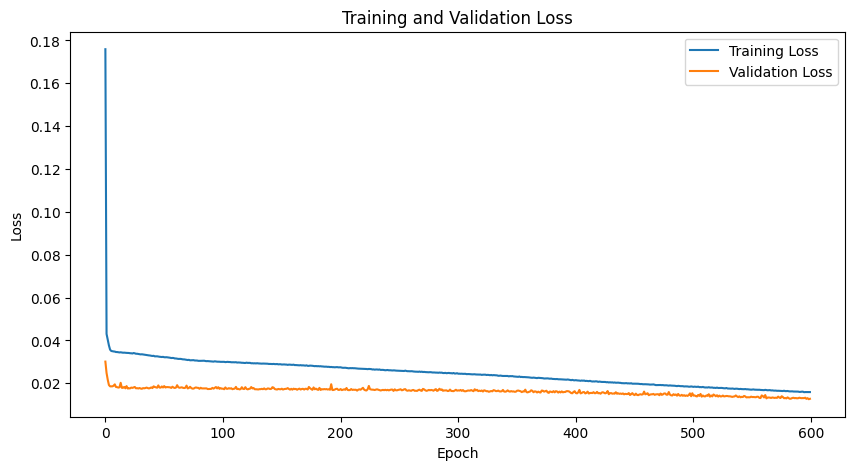

000001.SZ_平安银行_all2.xlsx: MAE=0.0498812235891819, MSE=0.005495542194694281, R2=-0.10648608770768897
000002.SZ_万科A_all2.xlsx: MAE=0.23022498190402985, MSE=0.08608800172805786, R2=-0.5486285131298521
000063.SZ_中兴通讯_all2.xlsx: MAE=0.08313009887933731, MSE=0.009653241373598576, R2=-0.0871226753309402
000100.SZ_TCL科技_all2.xlsx: MAE=0.10574572533369064, MSE=0.020763881504535675, R2=-0.1456471231721077
000157.SZ_中联重科_all2.xlsx: MAE=0.09358010441064835, MSE=0.01732538640499115, R2=-0.009026041574313748
000166.SZ_申万宏源_all2.xlsx: MAE=0.13108378648757935, MSE=0.02829637937247753, R2=-0.6892539804920614
000301.SZ_东方盛虹_all2.xlsx: MAE=0.10724139213562012, MSE=0.021903380751609802, R2=-0.3636314510842509
000333.SZ_美的集团_all2.xlsx: MAE=0.10383046418428421, MSE=0.020218992605805397, R2=-0.05497787094036388
000338.SZ_潍柴动力_all2.xlsx: MAE=0.030506722629070282, MSE=0.0014706007204949856, R2=-0.40080329064364095
000408.SZ_藏格矿业_all2.xlsx: MAE=0.14462018013000488, MSE=0.03427587077021599, R2=-1.142808060902332

In [1]:
# -修改说明：
# 数据检查与处理：在 load_and_preprocess_data 函数中，检查数据中是否存在 nan 或 inf 值，并将 inf 替换为 nan 后删除包含 nan 的行。
# 梯度裁剪：在 train_model 函数中，使用 torch.nn.utils.clip_grad_norm_ 对梯度进行裁剪，防止梯度爆炸。
# 减小学习率：将 learning_rate 从 0.001 减小到 0.0001，避免学习率过大导致损失值发散。
# 通过以上修改，应该可以解决训练损失值为 nan 的问题-r^2多了4个正值。
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt


def create_sequences(input_data, target_data, seq_length):
    """
    创建时间序列数据窗口
    :param input_data: 输入数据
    :param target_data: 目标数据
    :param seq_length: 时间序列长度
    :return: 序列输入和序列目标
    """
    sequences_x = []
    sequences_y = []
    for i in range(len(input_data) - seq_length):
        sequences_x.append(input_data[i:i + seq_length])
        sequences_y.append(target_data[i + seq_length])
    return np.array(sequences_x), np.array(sequences_y)


def load_and_preprocess_data(file_path):
    """
    加载并预处理数据
    :param file_path: 文件路径
    :param selected_columns: 要选择的列索引列表，默认为 [3, 5, 7, 12][开盘价、收盘价、涨跌、涨跌幅、MACD]
    :return: 预处理后的序列数据和所选列名列表
    """
    # 假设我们想要跳过名为'所属申万行业名称(2014)_[行业级别]一级行业'和'股票收益率1'的列
    skip_column_names = ['所属申万行业名称(2014)_[行业级别]一级行业', '股票收益率1']
    column_used = ['开盘价', '收盘价', '涨跌', '涨跌幅', 'RSI相对强弱指标_[周期数]6', '净买入额_[单位]元_[类型]机构', 'MACD指数平滑移动平均_[MACD指标选项]DIFF_[周期数]9_[短期周期数]12_[长期周期数]26', '股票收益率2']
    all_columns = pd.read_excel(file_path, nrows=0).columns
    columns_to_use = [col for col in all_columns if col in column_used]
    data = pd.read_excel(file_path, usecols=columns_to_use)
    data = data.iloc[7:, :]

    # 检查数据中是否存在 nan 或 inf 值
    if data.isnull().values.any() or np.isinf(data.values).any():
        data = data.replace([np.inf, -np.inf], np.nan).dropna()

    # x获取除 '股票收益率2' 列以外的数据
    # x = data.drop(columns=['股票收益率2']).values
    x = data.iloc[:, :].values #用上“股票收益率2”自身时间序列信息
    # y获取 '股票收益率2' 列的数据
    y = data['股票收益率2'].values

    # 数据标准化
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    x_scaled = scaler_x.fit_transform(x)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))
    return x_scaled, y_scaled


def train_model(model, train_loader, val_loader, num_epochs, learning_rate, device):
    """
    训练模型
    :param model: 模型
    :param train_loader: 训练数据加载器
    :param val_loader: 验证数据加载器
    :param num_epochs: 训练轮数
    :param learning_rate: 学习率
    :param device: 运行设备
    :return: 训练损失列表，验证损失列表
    """
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_losses = []
    val_losses = []
    # 将训练集和验证集数据合并
    all_train_data = ConcatDataset([train_loader.dataset, val_loader.dataset])
    all_train_loader = DataLoader(all_train_data, batch_size=32, shuffle=True)
    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        for inputs, targets in all_train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            # 梯度裁剪
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        train_losses.append(epoch_train_loss / len(all_train_loader))
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, targets).item()
        val_losses.append(val_loss / len(val_loader))
        print(f'Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_loss / len(val_loader)}')
    return train_losses, val_losses


def evaluate_model(model, test_loader, device):
    """
    评估模型
    :param model: 模型
    :param test_loader: 测试数据加载器
    :param device: 运行设备
    :return: 测试集上的 MAE, MSE, R2 指标
    """
    criterion = nn.MSELoss()
    model.eval()
    test_loss = 0
    test_predictions = []
    test_targets = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            test_loss += criterion(outputs, targets).item()
            test_predictions.extend(outputs.cpu().numpy().flatten())
            test_targets.extend(targets.cpu().numpy().flatten())
    test_loss /= len(test_loader)
    mae = mean_absolute_error(test_targets, test_predictions)
    mse = mean_squared_error(test_targets, test_predictions)
    r2 = r2_score(test_targets, test_predictions)
    return mae, mse, r2


def main():
    folder_path = 'E:/2412毕业论文/0104数据特征/wind250109/0109沪深300股票1/处理2/处理'
    time_windows = 10
    num_epochs = 600
    learning_rate = 0.0001  # 减小学习率
    input_size = 8  # 因为 x 是 data.iloc[:, 3:11].values
    hidden_size = 50
    num_layers = 2
    output_size = 1

    # 检查设备
    if torch.cuda.is_available():
        device = torch.device("cuda:0")  # 使用第一个 GPU
        print("GPU 可用，使用 GPU 加速")
    else:
        device = torch.device("cpu")
        print("GPU 不可用，使用 CPU")

    all_train_losses = []
    all_val_losses = []
    all_mae = []
    all_mse = []
    all_r2 = []

    # 存储所有公司的训练集、验证集和测试集数据
    all_train_x = []
    all_train_y = []
    all_val_x = []
    all_val_y = []
    all_test_x = []
    all_test_y = []

    file_list = []

    for file in os.listdir(folder_path):
        if file.endswith('.xlsx'):
            file_list.append(file)
            file_path = os.path.join(folder_path, file)
            x_scaled, y_scaled = load_and_preprocess_data(file_path)  # 1.先读取文件
            sequences_x, sequences_y = create_sequences(x_scaled, y_scaled, time_windows)  # 2.滑动窗口造样本
            sequences_x = torch.FloatTensor(sequences_x).to(device)
            sequences_y = torch.FloatTensor(sequences_y).to(device)
            train_size = int(0.7 * len(sequences_x))
            val_size = int(0.2 * len(sequences_x))
            test_size = len(sequences_x) - train_size - val_size
            train_x = sequences_x[:train_size]
            train_y = sequences_y[:train_size]
            val_x = sequences_x[train_size:train_size + val_size]  # 针对时间窗口，尽可能使用所有数据序列
            val_y = sequences_y[train_size:train_size + val_size]
            all_train_x.append(train_x)
            all_train_y.append(train_y)
            all_val_x.append(val_x)
            all_val_y.append(val_y)
            all_test_x.append(sequences_x[train_size + val_size:])
            all_test_y.append(sequences_y[train_size + val_size:])

    # 合并所有公司的训练集和验证集数据
    train_x = torch.cat(all_train_x, dim=0)
    train_y = torch.cat(all_train_y, dim=0)
    val_x = torch.cat(all_val_x, dim=0)
    val_y = torch.cat(all_val_y, dim=0)

    train_dataset = TensorDataset(train_x, train_y)
    val_dataset = TensorDataset(val_x, val_y)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # 3.混合样本
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

    model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
    # 1.训练
    train_losses, val_losses = train_model(model, train_loader, val_loader, num_epochs, learning_rate, device)

    # 2.验证mae,mse
    for i, file in enumerate(file_list):
        test_x = all_test_x[i]
        test_y = all_test_y[i]
        test_dataset = TensorDataset(test_x, test_y)
        test_loader = DataLoader(test_dataset, batch_size=32)
        mae, mse, r2 = evaluate_model(model, test_loader, device)
        all_mae.append(mae)
        all_mse.append(mse)
        all_r2.append(r2)

    all_train_losses.extend(train_losses)
    all_val_losses.extend(val_losses)

    # 绘制损失曲线
    plt.figure(figsize=(10, 5))
    plt.plot(all_train_losses, label='Training Loss')
    plt.plot(all_val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

    # 输出每个公司的指标结果
    for i, file in enumerate(file_list):
        print(f'{file}: MAE={all_mae[i]}, MSE={all_mse[i]}, R2={all_r2[i]}')

    # 存储模型
    model_save_path = 'best_lstm_model.pth'
    torch.save(model.state_dict(), model_save_path)
    print(f"模型已存储在 {model_save_path}")


class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out


if __name__ == "__main__":
    main()

### 4.ray tune超参数优化

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

os.environ["RAY_TMPDIR"] = "E:\\2412毕业论文\\0104模型构建\\ray_temp"  # 你可以指定一个合适的目录

def create_sequences(input_data, target_data, seq_length):
    """
    创建时间序列数据窗口
    :param input_data: 输入数据
    :param target_data: 目标数据
    :param seq_length: 时间序列长度
    :return: 序列输入和序列目标
    """
    sequences_x = []
    sequences_y = []
    for i in range(len(input_data) - seq_length):
        sequences_x.append(input_data[i:i + seq_length])
        sequences_y.append(target_data[i + seq_length])
    return np.array(sequences_x), np.array(sequences_y)


def load_and_preprocess_data(file_path):
    """
    加载并预处理数据
    :param file_path: 文件路径
    :param selected_columns: 要选择的列索引列表，默认为 [3, 5, 7, 12][开盘价、收盘价、涨跌、涨跌幅、MACD]
    :return: 预处理后的序列数据和所选列名列表
    """
    # 假设我们想要跳过名为'所属申万行业名称(2014)_[行业级别]一级行业'和'股票收益率1'的列
    skip_column_names = ['所属申万行业名称(2014)_[行业级别]一级行业', '股票收益率1']
    column_used = ['开盘价', '收盘价', '涨跌', '涨跌幅', 'RSI相对强弱指标_[周期数]6', '净买入额_[单位]元_[类型]机构',
                   'MACD指数平滑移动平均_[MACD指标选项]DIFF_[周期数]9_[短期周期数]12_[长期周期数]26', '股票收益率2']
    all_columns = pd.read_excel(file_path, nrows=0).columns
    columns_to_use = [col for col in all_columns if col in column_used]
    data = pd.read_excel(file_path, usecols=columns_to_use)
    data = data.iloc[7:, :]

    # 检查数据中是否存在 nan 或 inf 值
    if data.isnull().values.any() or np.isinf(data.values).any():
        data = data.replace([np.inf, -np.inf], np.nan).dropna()

    # x获取除 '股票收益率2' 列以外的数据
    # x = data.drop(columns=['股票收益率2']).values
    x = data.iloc[:, :].values  # 用上“股票收益率2”自身时间序列信息
    # y获取 '股票收益率2' 列的数据
    y = data['股票收益率2'].values

    # 数据标准化
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    x_scaled = scaler_x.fit_transform(x)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))
    return x_scaled, y_scaled


def train_model(model, train_loader, val_loader, num_epochs, learning_rate, device):
    """
    训练模型
    :param model: 模型
    :param train_loader: 训练数据加载器
    :param val_loader: 验证数据加载器
    :param num_epochs: 训练轮数
    :param learning_rate: 学习率
    :param device: 运行设备
    :return: 训练损失列表，验证损失列表
    """
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_losses = []
    val_losses = []
    # 将训练集和验证集数据合并
    all_train_data = ConcatDataset([train_loader.dataset, val_loader.dataset])
    all_train_loader = DataLoader(all_train_data, batch_size=32, shuffle=True)
    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        for inputs, targets in all_train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            # 梯度裁剪
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        train_losses.append(epoch_train_loss / len(all_train_loader))
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, targets).item()
        val_losses.append(val_loss / len(val_loader))
    return train_losses, val_losses


def evaluate_model(model, test_loader, device):
    """
    评估模型
    :param model: 模型
    :param test_loader: 测试数据加载器
    :param device: 运行设备
    :return: 测试集上的 MAE, MSE, R2 指标
    """
    criterion = nn.MSELoss()
    model.eval()
    test_loss = 0
    test_predictions = []
    test_targets = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            test_loss += criterion(outputs, targets).item()
            test_predictions.extend(outputs.cpu().numpy().flatten())
            test_targets.extend(targets.cpu().numpy().flatten())
    test_loss /= len(test_loader)
    mae = mean_absolute_error(test_targets, test_predictions)
    mse = mean_squared_error(test_targets, test_predictions)
    r2 = r2_score(test_targets, test_predictions)
    return mae, mse, r2


def trainable(config):
    folder_path = 'E:/2412毕业论文/0104数据特征/wind250109/0109沪深300股票1/处理2/处理'
    time_windows = config["time_windows"]
    input_size = 8  # 因为 x 是 data.iloc[:, 3:11].values
    num_epochs = config["num_epochs"]
    learning_rate = config["learning_rate"]
    hidden_size = config["hidden_size"]
    num_layers = config["num_layers"]
    output_size = 1

    # 检查设备
    if torch.cuda.is_available():
        device = torch.device("cuda:0")  # 使用第一个 GPU
    else:
        device = torch.device("cpu")

    all_train_x = []
    all_train_y = []
    all_val_x = []
    all_val_y = []
    all_test_x = []
    all_test_y = []

    file_list = []

    for file in os.listdir(folder_path):
        if file.endswith('.xlsx'):
            file_list.append(file)
            file_path = os.path.join(folder_path, file)
            x_scaled, y_scaled = load_and_preprocess_data(file_path)  # 1.先读取文件
            sequences_x, sequences_y = create_sequences(x_scaled, y_scaled, time_windows)  # 2.滑动窗口造样本
            sequences_x = torch.FloatTensor(sequences_x).to(device)
            sequences_y = torch.FloatTensor(sequences_y).to(device)
            train_size = int(0.7 * len(sequences_x))
            val_size = int(0.2 * len(sequences_x))
            test_size = len(sequences_x) - train_size - val_size
            train_x = sequences_x[:train_size]
            train_y = sequences_y[:train_size]
            val_x = sequences_x[train_size:train_size + val_size]  # 针对时间窗口，尽可能使用所有数据序列
            val_y = sequences_y[train_size:train_size + val_size]
            all_train_x.append(train_x)
            all_train_y.append(train_y)
            all_val_x.append(val_x)
            all_val_y.append(val_y)
            all_test_x.append(sequences_x[train_size + val_size:])
            all_test_y.append(sequences_y[train_size + val_size:])

    # 合并所有公司的训练集和验证集数据
    train_x = torch.cat(all_train_x, dim=0)
    train_y = torch.cat(all_train_y, dim=0)
    val_x = torch.cat(all_val_x, dim=0)
    val_y = torch.cat(all_val_y, dim=0)

    train_dataset = TensorDataset(train_x, train_y)
    val_dataset = TensorDataset(val_x, val_y)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # 3.混合样本
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

    model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
    # 1.训练
    train_losses, val_losses = train_model(model, train_loader, val_loader, num_epochs, learning_rate, device)

    # 2.验证mae,mse
    all_mae = []
    all_mse = []
    all_r2 = []
    for i, file in enumerate(file_list):
        test_x = all_test_x[i]
        test_y = all_test_y[i]
        test_dataset = TensorDataset(test_x, test_y)
        test_loader = DataLoader(test_dataset, batch_size=32)
        mae, mse, r2 = evaluate_model(model, test_loader, device)
        all_mae.append(mae)
        all_mse.append(mse)
        all_r2.append(r2)

    # 这里我们以平均R2作为优化目标
    mean_r2 = np.mean(all_r2)
    tune.report(r2=mean_r2)


class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out


def main():
    # 定义超参数搜索空间
    config = {
        "time_windows": tune.randint(20, 60),
        "num_epochs": tune.randint(100, 1000),
        "learning_rate": tune.loguniform(1e-5, 1e-2),
        "hidden_size": tune.randint(20, 100),
        "num_layers": tune.randint(1, 5)
    }

    # 定义调度器和报告器
    scheduler = ASHAScheduler(
        metric="r2",
        mode="max",
        max_t=1000,
        grace_period=10,
        reduction_factor=2
    )
    reporter = CLIReporter(
        metric_columns=["r2", "training_iteration"]
    )

    # 进行超参数优化
    result = tune.run(
        trainable,
        config=config,
        scheduler=scheduler,
        progress_reporter=reporter,
        num_samples=50
    )

    # 输出最佳超参数
    best_trial = result.get_best_trial("r2", "max", "last")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial R2: {}".format(best_trial.last_result["r2"]))


if __name__ == "__main__":
    main()

2025-02-15 14:36:47,906	INFO tune.py:613 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949
2025-02-15 14:36:48,022	WARNING trial.py:648 -- The path to the trial log directory is too long (max length: 260. Consider using `trial_dirname_creator` to shorten the path. Path: C:\Users\Morton\AppData\Local\Temp\ray\session_2025-02-15_14-32-36_800473_24532\artifacts\2025-02-15_14-36-47\trainable_2025-02-15_14-36-47\driver_artifacts\trainable_3b33d_00000_0_hidden_size=50,learning_rate=0.0000,num_epochs=151,num_layers=1,time_windows=40_2025-02-15_14-36-48


FileNotFoundError: [WinError 3] 系统找不到指定的路径。: 'C:\\Users\\Morton\\AppData\\Local\\Temp\\ray\\session_2025-02-15_14-32-36_800473_24532\\artifacts\\2025-02-15_14-36-47\\trainable_2025-02-15_14-36-47\\driver_artifacts\\trainable_3b33d_00000_0_hidden_size=50,learning_rate=0.0000,num_epochs=151,num_layers=1,time_windows=40_2025-02-15_14-36-48'